In [ ]:
%matplotlib inline

import numpy as np

### 基於常態分佈的平均值和標準差來生成隨機樣本

In [ ]:
def sample_z(mu, sigma):
    epsilon = np.random.normal(0, 1, mu.shape)
    return mu + sigma * epsilon

# 假設的平均值和標準差

mu = np.array([1, 2])
sigma = np.array([0.5, 1.0])

# 生成樣本

z = sample_z(mu, sigma)
print("Sampled z:", z)

Sampled z: [1.02843453 2.55087451]


### 將輸出改為 $log𝜎$


In [ ]:
def sample_z(mu, log_sigma):
    sigma = np.exp(log_sigma)  # 計算標準差 sigma
    epsilon = np.random.normal(0, 1, mu.shape)
    return mu + sigma * epsilon

# 假設的平均值和log(標準差)

mu = np.array([1, 2])
log_sigma = np.array([-0.693147, 0])  # log(0.5) ≈ -0.693, log(1) = 0

# 生成樣本

z = sample_z(mu, log_sigma)
print("Sampled z:", z)

Sampled z: [0.35970036 2.35506351]


### 使用Box-Muller變換生成標準常態分佈隨機樣本

In [ ]:
def box_muller():
    U1, U2 = np.random.uniform(low=0.0, high=1.0, size=2)  # 生成兩個[0,1]均勻分布的隨機數
    Z0 = np.sqrt(-2.0 * np.log(U1)) * np.cos(2 * np.pi * U2)
    Z1 = np.sqrt(-2.0 * np.log(U1)) * np.sin(2 * np.pi * U2)
    return Z0, Z1  # 返回兩個標準常態分布的隨機數

# 生成一對標準常態分佈隨機數

z0, z1 = box_muller()
print("Sampled z0:", z0)
print("Sampled z1:", z1)

Sampled z0: -0.4895213121497116
Sampled z1: -0.4452975407451724


### 用MNIST數據集實作VAE

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.datasets import mnist
from tensorflow.keras import backend as K

In [ ]:
import matplotlib.pyplot as plt

Epoch 1/50
600/600 [==============================] - 8s 13ms/step - loss: 0.0750 - val_loss: 0.0621
Epoch 2/50
600/600 [==============================] - 7s 11ms/step - loss: 0.0604 - val_loss: 0.0591
Epoch 3/50
600/600 [==============================] - 8s 13ms/step - loss: 0.0583 - val_loss: 0.0574
Epoch 4/50
600/600 [==============================] - 7s 11ms/step - loss: 0.0569 - val_loss: 0.0560
Epoch 5/50
600/600 [==============================] - 7s 12ms/step - loss: 0.0556 - val_loss: 0.0549
Epoch 6/50
600/600 [==============================] - 6s 10ms/step - loss: 0.0545 - val_loss: 0.0537
Epoch 7/50
600/600 [==============================] - 8s 13ms/step - loss: 0.0537 - val_loss: 0.0530
Epoch 8/50
600/600 [==============================] - 7s 12ms/step - loss: 0.0531 - val_loss: 0.0525
Epoch 9/50
600/600 [==============================] - 7s 12ms/step - loss: 0.0526 - val_loss: 0.0521
Epoch 10/50
600/600 [==============================] - 8s 13ms/step - loss: 0.0522 - val_lo

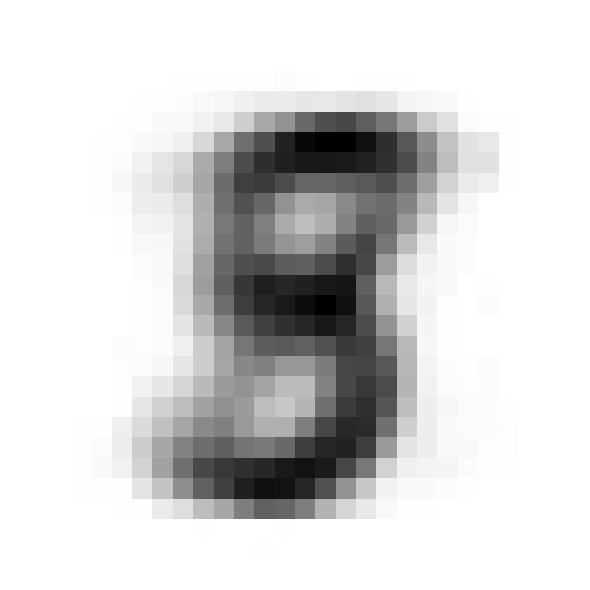

In [ ]:
# 參數設定
original_dim = 784  # 28*28 pixels
intermediate_dim = 256
latent_dim = 2
batch_size = 100
epochs = 50

# 加載數據
(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.reshape(-1, original_dim) / 255.
x_test = x_test.reshape(-1, original_dim) / 255.

# 建立 VAE 模型的編碼器部分
inputs = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.random.normal(shape=(tf.shape(z_mean)[0], latent_dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# 建立解碼器部分
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

# 完整 VAE 模型
vae = Model(inputs, x_decoded_mean)
encoder = Model(inputs, [z_mean, z_log_var])

z_input = Input(shape=(latent_dim,))
h_decoded_sample = decoder_h(z_input)
x_decoded_sample = decoder_mean(h_decoded_sample)
decoder = Model(z_input, x_decoded_sample)

# 訓練 VAE
vae.compile(optimizer='rmsprop', loss='mse')
vae.fit(x_train, x_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, x_test))

# 獲得潛在向量並重建圖像
z_mean, z_log_var = encoder.predict(x_train[0:1])
z_sample = sampling((z_mean, z_log_var))
x_decoded = decoder.predict(z_sample)

# 顯示重建後的圖像
plt.figure(figsize=(6, 6))
plt.imshow(x_decoded[0].reshape(28, 28), cmap='gray_r')  # 使用反向灰度圖顯示為白底黑字
plt.axis('off')  # 移除坐標軸
plt.tight_layout()  # 調整布局
plt.show()

### 展示所有潛在向量（latent vectors）的分佈，可以使用encoder將MNIST的資料集中的所有圖像轉換到latent space中，並繪製散點圖來觀察分佈情況

Epoch 1/50
600/600 [==============================] - 8s 13ms/step - loss: 0.0740 - val_loss: 0.0622
Epoch 2/50
600/600 [==============================] - 6s 10ms/step - loss: 0.0602 - val_loss: 0.0591
Epoch 3/50
600/600 [==============================] - 8s 13ms/step - loss: 0.0581 - val_loss: 0.0572
Epoch 4/50
600/600 [==============================] - 6s 11ms/step - loss: 0.0566 - val_loss: 0.0560
Epoch 5/50
600/600 [==============================] - 8s 13ms/step - loss: 0.0554 - val_loss: 0.0547
Epoch 6/50
600/600 [==============================] - 7s 12ms/step - loss: 0.0542 - val_loss: 0.0536
Epoch 7/50
600/600 [==============================] - 7s 11ms/step - loss: 0.0532 - val_loss: 0.0526
Epoch 8/50
600/600 [==============================] - 8s 13ms/step - loss: 0.0524 - val_loss: 0.0519
Epoch 9/50
600/600 [==============================] - 7s 11ms/step - loss: 0.0519 - val_loss: 0.0515
Epoch 10/50
600/600 [==============================] - 8s 13ms/step - loss: 0.0515 - val_lo

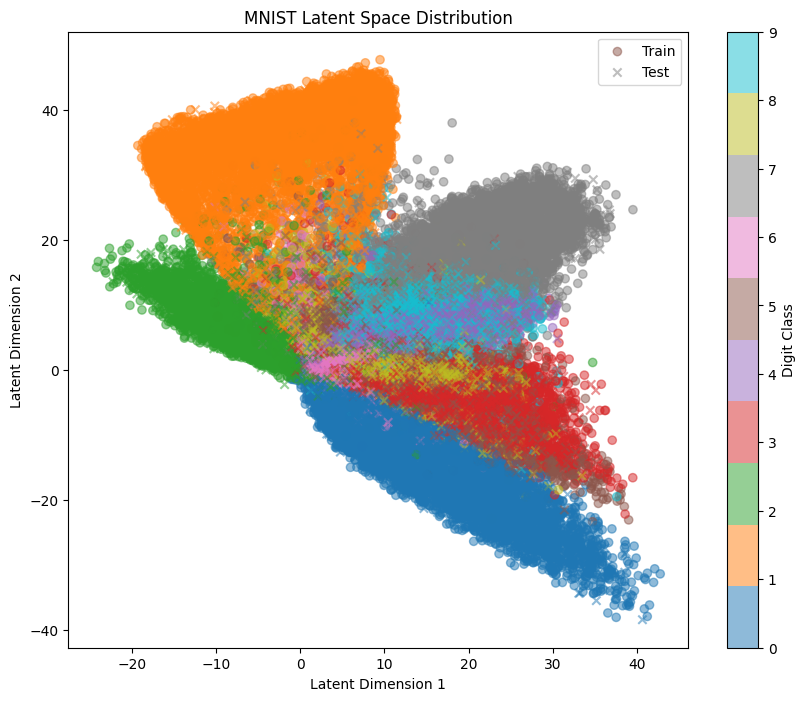

In [ ]:
# 參數設定
original_dim = 784  # 28*28 pixels
intermediate_dim = 256
latent_dim = 2
batch_size = 100
epochs = 50

# 加載數據
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(-1, original_dim) / 255.
x_test = x_test.reshape(-1, original_dim) / 255.

# 建立 VAE 模型的編碼器部分
inputs = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.random.normal(shape=(tf.shape(z_mean)[0], latent_dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# 建立解碼器部分
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

# 完整 VAE 模型
vae = Model(inputs, x_decoded_mean)
encoder = Model(inputs, [z_mean, z_log_var, z])

z_input = Input(shape=(latent_dim,))
h_decoded_sample = decoder_h(z_input)
x_decoded_sample = decoder_mean(h_decoded_sample)
decoder = Model(z_input, x_decoded_sample)

# 訓練 VAE
vae.compile(optimizer='rmsprop', loss='mse')
vae.fit(x_train, x_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, x_test))

# 獲得訓練集和測試集的潛在向量
z_train = encoder.predict(x_train)[-1]
z_test = encoder.predict(x_test)[-1]

# 畫訓練集和測試集的潛在向量分佈
plt.figure(figsize=(10, 8))
plt.scatter(z_train[:, 0], z_train[:, 1], c=y_train, cmap='tab10', alpha=0.5, label='Train')
plt.scatter(z_test[:, 0], z_test[:, 1], c=y_test, cmap='tab10', alpha=0.5, marker='x', label='Test')
plt.colorbar(label='Digit Class')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('MNIST Latent Space Distribution')
plt.legend()
plt.show()
